In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('./hockenberry.mplstyle')

import statsmodels.formula.api as smf
import seaborn as sns

###The following is used to create some sensible results folders according to the year/month
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

# Defining constants

The `sparse_data` flag refers to whether I want to use the "full" dataset of gene expression conditions (n = 103) or a more sparsely populated / thinned down dataset containing less redundancy (n=30, where there less underlying structure between the conditions).

In [3]:
sparse_data = False
save_figs = True

if sparse_data and save_figs:
    figs_dir += '/sparse_data'
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)

# Read in the data

In [4]:
if sparse_data:
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_SPARSE.tsv', sep='\t', index_col=0)
else:
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata.tsv', sep='\t', index_col=0)
print(meta_df.shape)
meta_df.head()

(103, 27)


,Sample ID,Study,Project ID,Condition ID,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,...,Additional Details,DOI,GEO,Simple_sample_id,Temperature (C),pH,Growth Rate (1/hr),Alignment,Replicate #,Doubling_time
4,fur__wt_fe__1,Fur,fur,wt_fe,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms5910,GSE54900,fur__wt_fe,37,7.0,1.060606,92.865,2,0.653539
8,fur__delfur_fe2__1,Fur,fur,delfur_fe2,Escherichia coli K-12 MG1655 del_fur,MG1655,M9,glucose(2),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms5910,GSE54900,fur__delfur_fe2,37,7.0,0.619469,93.020,2,1.118938
55,omics__bw_ac__1,Omics,omics,bw_ac,Escherichia coli BW25113,BW25113,M9,acetate(3.5),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_ac,37,7.0,0.203000,97.920,2,3.414518
57,omics__bw_fum__1,Omics,omics,bw_fum,Escherichia coli BW25113,BW25113,M9,fumarate(2.8),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_fum,37,7.0,0.309000,98.130,2,2.243195
59,omics__bw_glc__1,Omics,omics,bw_glc,Escherichia coli BW25113,BW25113,M9,glucose(5),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_glc,37,7.0,0.607500,97.875,2,1.140983


In [5]:
if sparse_data:
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_SPARSE.tsv', sep='\t', index_col=0)
else:
    exp_df = pd.read_csv('../Data/processed_data/processed_expression.tsv', sep='\t', index_col=0)
print(exp_df.shape)
exp_df.head()

(3923, 103)


,fur__wt_fe,fur__delfur_fe2,omics__bw_ac,omics__bw_fum,omics__bw_glc,omics__bw_pyr,cra_crp__wt_ac,cra_crp__wt_fru,cra_crp__delcra_ac,cra_crp__delcra_fru,...,pal__tartr_ale26_f10,pal__tartr_ale26,pal__tartr_ale28_f10,pal__tartr_ale28,efeU__menFentC_ale39,efeU__menFentC_ale29,efeU__menFentC_ale30,efeU__menFentCubiC_ale36,efeU__menFentCubiC_ale37,efeU__menFentCubiC_ale38
log-TPM,,,,,,,,,,,,,,,,,,,,,
b0002,10.921941,11.221916,9.219835,9.690669,10.213469,10.706351,9.568949,11.198040,8.487038,11.649292,...,7.907166,8.768993,7.738432,8.134838,10.344302,10.273946,11.159558,11.701351,11.902383,11.524586
b0003,10.687397,10.879548,8.963280,9.415289,9.643784,10.197705,8.831856,10.182029,8.546123,11.392722,...,8.026256,8.604928,7.832378,7.992993,10.265772,10.138576,10.353287,10.912852,11.031175,10.694248
b0004,10.254460,10.174903,8.770805,9.533522,9.876957,10.377069,8.680003,10.037740,7.748146,10.717654,...,8.090676,8.717934,7.802900,8.173352,10.712971,10.454710,10.701747,11.128015,11.213320,10.977106
b0005,6.563467,6.331911,4.597347,5.554385,5.909349,6.082721,4.576969,6.058802,3.399998,5.471490,...,3.684667,4.435953,4.044967,4.050593,6.245881,5.842332,6.298730,4.947044,5.603024,5.841291
b0006,6.789173,6.839814,6.488187,6.342374,6.876792,6.650875,6.273174,6.555468,6.647096,6.973928,...,6.635715,6.886069,6.236603,6.675508,7.161943,8.346839,8.104676,7.359833,7.321431,8.081482


In [6]:
if sparse_data:
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_SPARSE.tsv', sep='\t', index_col=0)
else:
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary.tsv', sep='\t', index_col=0)


print(exp_summary_df.shape)
exp_summary_df.head()

(3923, 13)


,count,mean,std,min,25_percentile,50_percentile,75_percentile,max,cv,noise,lin_slope,lin_r,spearmans_rho
log-TPM,,,,,,,,,,,,,
b0002,103.0,10.028859,1.793338,0.056428,9.598118,10.504998,11.080190,12.361644,0.178818,0.031976,0.023834,0.150471,0.215259
b0003,103.0,9.776098,1.009884,7.265206,9.123471,10.023056,10.493901,11.883905,0.103301,0.010671,0.042490,0.151057,0.182895
b0004,103.0,9.849752,1.033603,7.371951,9.149693,10.104900,10.618291,11.992770,0.104937,0.011012,0.038633,0.140572,0.149976
b0005,103.0,5.550056,0.987474,1.878805,4.834444,5.705243,6.201346,7.551687,0.177922,0.031656,0.074243,0.258088,0.412982
b0006,103.0,6.851846,0.407601,5.285927,6.653258,6.849328,7.024589,8.346839,0.059488,0.003539,0.169540,0.243273,0.243724


# Explore the relationship between conditions

In [7]:
cond_corr_mat = exp_df.corr(method='spearman')
cond_corr_mat.head()

,fur__wt_fe,fur__delfur_fe2,omics__bw_ac,omics__bw_fum,omics__bw_glc,omics__bw_pyr,cra_crp__wt_ac,cra_crp__wt_fru,cra_crp__delcra_ac,cra_crp__delcra_fru,...,pal__tartr_ale26_f10,pal__tartr_ale26,pal__tartr_ale28_f10,pal__tartr_ale28,efeU__menFentC_ale39,efeU__menFentC_ale29,efeU__menFentC_ale30,efeU__menFentCubiC_ale36,efeU__menFentCubiC_ale37,efeU__menFentCubiC_ale38
fur__wt_fe,1.000000,0.964640,0.923339,0.917715,0.962571,0.935009,0.901038,0.926609,0.904316,0.943159,...,0.866013,0.866432,0.858613,0.918781,0.873224,0.850732,0.928566,0.934770,0.939126,0.927869
fur__delfur_fe2,0.964640,1.000000,0.913742,0.903783,0.952763,0.924470,0.898731,0.914061,0.924542,0.961016,...,0.854125,0.849878,0.858827,0.901197,0.840142,0.834696,0.896473,0.942488,0.946356,0.904614
omics__bw_ac,0.923339,0.913742,1.000000,0.967975,0.942483,0.972111,0.943399,0.930222,0.931166,0.885828,...,0.907638,0.897741,0.903667,0.949034,0.839838,0.817468,0.878564,0.884267,0.884292,0.869539
omics__bw_fum,0.917715,0.903783,0.967975,1.000000,0.956253,0.974362,0.902824,0.916864,0.892215,0.869514,...,0.867798,0.873566,0.850602,0.940838,0.842448,0.820857,0.897118,0.879182,0.874671,0.884392
omics__bw_glc,0.962571,0.952763,0.942483,0.956253,1.000000,0.966576,0.885214,0.913576,0.897124,0.932456,...,0.856878,0.858610,0.856949,0.925330,0.867961,0.851744,0.924271,0.932579,0.932818,0.925066


/Users/adamhockenberry/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


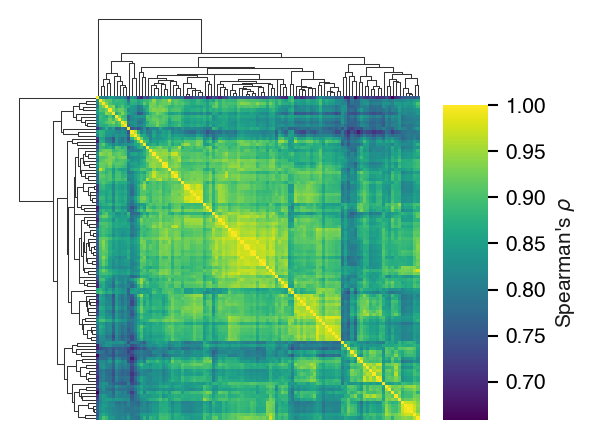

In [8]:
ax = sns.clustermap(cond_corr_mat, yticklabels=False, xticklabels=False, cmap='viridis',\
               cbar_pos=[1.0, 0.05, 0.1, 0.7], figsize=(3,3), cbar_kws={'label': r"Spearman's $\rho$"})
ax.ax_cbar.tick_params(labelsize=10)
if save_figs:
    plt.savefig(figs_dir+'/condition_corr_mat.pdf', bbox_inches='tight')

## Example scatterplots of two highly correlated conditions

In [9]:
mask = np.ones(cond_corr_mat.values.shape, dtype=bool)
np.fill_diagonal(mask, 0)
print(mask.shape)

tempy = (cond_corr_mat.values*mask).flatten()
tempy.sort()
print(tempy[-20:])

(103, 103)
[0.9869214  0.9869214  0.98731504 0.98731504 0.98830799 0.98830799
 0.98921482 0.98921482 0.99042384 0.99042384 0.99121855 0.99121855
 0.99249022 0.99249022 0.99307267 0.99307267 0.99307628 0.99307628
 0.99387794 0.99387794]


In [10]:
example_index = -5
result = np.where(cond_corr_mat.values*mask == np.amax(tempy[example_index]))
print('Max', result)

Max (array([81, 82]), array([82, 81]))


In [11]:
idx_a = result[0][0]
idx_b = result[0][1]
cols = cond_corr_mat.columns
cond_corr_mat.loc[cols[idx_a]][cols[idx_b]]

0.9930726746889074

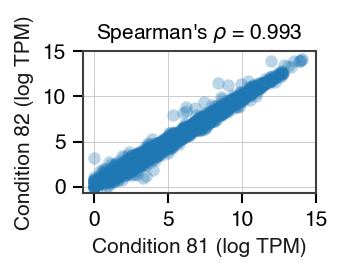

In [12]:
rho, p = stats.spearmanr(exp_df[cols[idx_a]], exp_df[cols[idx_b]])
fig, ax = plt.subplots(figsize=(2.,1.25))
ax.plot(exp_df[cols[idx_a]], exp_df[cols[idx_b]], marker='o', linestyle='', alpha=0.3)
ax.set_xticks([0, 5, 10, 15])
ax.set_yticks([0, 5, 10, 15])
ax.set_xlabel('Condition {} (log TPM)'.format(idx_a))
ax.set_ylabel('Condition {} (log TPM)'.format(idx_b))
ax.set_title(r"Spearman's $\rho$ = {:.3f}".format(rho))
if save_figs:
    plt.savefig(figs_dir+'/max_condition_corr.pdf', bbox_inches='tight')

## Example scatterplots of two minimally correlated conditions

In [13]:
tempy = cond_corr_mat.values.flatten()
tempy.sort()
print(tempy[:10])

[0.65866741 0.65866741 0.66355454 0.66355454 0.67887044 0.67887044
 0.68691037 0.68691037 0.68766216 0.68766216]


In [14]:
example_index = 0
result = np.where(cond_corr_mat.values == tempy[example_index])
print('Min', result)

Min (array([44, 56]), array([56, 44]))


In [15]:
cols = cond_corr_mat.columns
idx_a = result[0][0]
idx_b = result[0][1]
cols = cond_corr_mat.columns
cond_corr_mat.loc[cols[idx_a]][cols[idx_b]]

0.6586674118797052

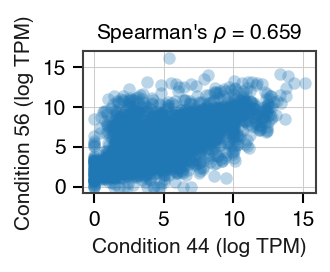

In [16]:
rho, p = stats.spearmanr(exp_df[cols[idx_a]], exp_df[cols[idx_b]])
fig, ax = plt.subplots(figsize=(2.,1.25))
ax.plot(exp_df[cols[idx_a]], exp_df[cols[idx_b]], marker='o', linestyle='', alpha=0.3)
ax.set_xlabel('Condition {} (log TPM)'.format(idx_a))
ax.set_ylabel('Condition {} (log TPM)'.format(idx_b))
ax.set_title(r"Spearman's $\rho$ = {:.3f}".format(rho))
ax.set_xticks([0, 5, 10, 15])
ax.set_yticks([0, 5, 10, 15])
if save_figs:
    plt.savefig(figs_dir+'/min_condition_corr.pdf', bbox_inches='tight')

## Looking at gene expression vs various dispersion metrics

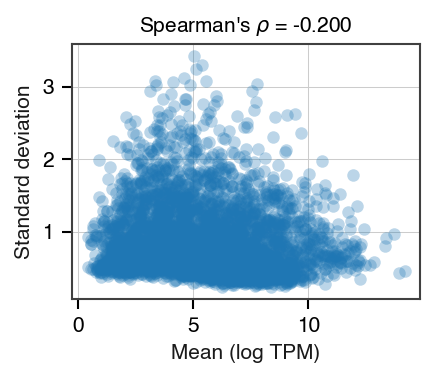

In [17]:
x_vals = exp_df.mean(axis=1)
y_vals = exp_df.std(axis=1)
rho, p = stats.spearmanr(x_vals, y_vals)
fig, ax = plt.subplots()
ax.plot(x_vals, y_vals, marker='o', linestyle='', alpha=0.3)
ax.set_xlabel('Mean (log TPM)')
ax.set_ylabel('Standard deviation')
ax.set_title(r"Spearman's $\rho$ = {:.3f}".format(rho));
if save_figs:
    plt.savefig(figs_dir+'/sdev_vs_mean.pdf', bbox_inches='tight')

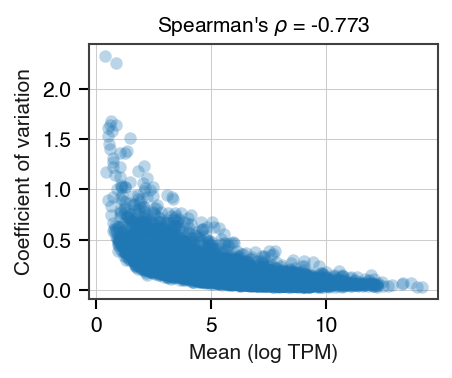

In [18]:
x_vals = exp_df.mean(axis=1)
y_vals = np.power(exp_df.std(axis=1), 1)/np.power(exp_df.mean(axis=1), 1)
rho, p = stats.spearmanr(x_vals, y_vals)
fig, ax = plt.subplots()
ax.plot(x_vals, y_vals, marker='o', linestyle='', alpha=0.3)
ax.set_xlabel('Mean (log TPM)')
ax.set_ylabel('Coefficient of variation')
ax.set_title(r"Spearman's $\rho$ = {:.3f}".format(rho));
if save_figs:
    plt.savefig(figs_dir+'/cv_vs_mean.pdf', bbox_inches='tight')

# Explore growth rate data

Slowest DT: 9.902102579427789
Fastest DT: 0.4881318172957361
Slowest rate: 0.07
Fastest DT: 1.42


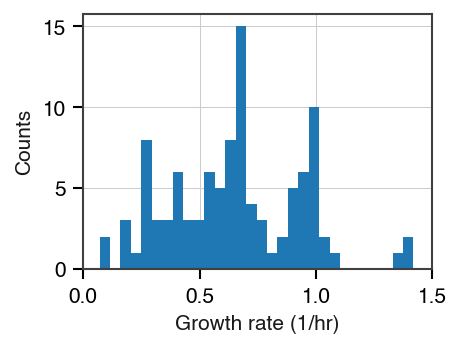

In [19]:
fig, ax = plt.subplots()
ax.hist(meta_df['Growth Rate (1/hr)'], 30)
ax.set_xlabel('Growth rate (1/hr)')
ax.set_ylabel('Counts')
assert meta_df['Growth Rate (1/hr)'].max() < 1.5
ax.set_xlim(0, 1.5)
if save_figs:
    plt.savefig(figs_dir+'/growth_rate_hist.pdf', bbox_inches='tight')
print('Slowest DT: {}'.format(np.log(2)/meta_df['Growth Rate (1/hr)'].min()))
print('Fastest DT: {}'.format(np.log(2)/meta_df['Growth Rate (1/hr)'].max()))
print('Slowest rate: {}'.format(meta_df['Growth Rate (1/hr)'].min()))
print('Fastest DT: {}'.format(meta_df['Growth Rate (1/hr)'].max()))

## PCA to determine the signature of growth rate variation within the expression data

In [20]:
from sklearn.decomposition import PCA, KernelPCA
from scipy.stats import zscore

In [21]:
pca = PCA(n_components=10)
pca_transform = pca.fit_transform(exp_df.T.values)
print('PCA variance:\t\t', pca.explained_variance_ratio_)

explained_variance = np.var(exp_df.values.T, axis=0)
explained_variance_ratio = np.var(pca_transform, axis=0) / np.sum(explained_variance)
print('PCA variance by hand:\t', explained_variance_ratio)
print()
print('Total PCA variance:', np.sum(explained_variance_ratio))
print()
print('PCA shape:', pca_transform.shape)
print()
print('Correlations with growth rate (PCA index, correlation results):')
r_list = []
for i in range(pca_transform.shape[1]):
    r, p = stats.pearsonr(pca_transform[:,i], meta_df['Growth Rate (1/hr)'])
    print(i, r, p)
    r_list.append(r)

PCA variance:		 [0.18996465 0.14623236 0.10336877 0.07909771 0.07000801 0.04237551
 0.02912538 0.02266744 0.0214884  0.01943199]
PCA variance by hand:	 [0.18996465 0.14623236 0.10336877 0.07909771 0.07000801 0.04237551
 0.02912538 0.02266744 0.0214884  0.01943199]

Total PCA variance: 0.7237602327676311

PCA shape: (103, 10)

Correlations with growth rate (PCA index, correlation results):
0 -0.6342378879647785 6.373094060657097e-13
1 0.23382046112785873 0.01744893987107623
2 -0.02099823150105698 0.83325314367165
3 -0.030527280368527084 0.7595221710931158
4 0.43255772074280074 5.042435425439795e-06
5 -0.1745700533278908 0.07779270718040564
6 -0.018409111221819915 0.8535682322237133
7 0.06083036436545073 0.5416021513318967
8 0.07774375794465985 0.4350577418140689
9 -0.002757044847951641 0.9779496674777445


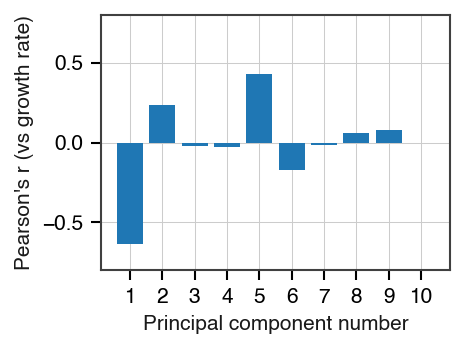

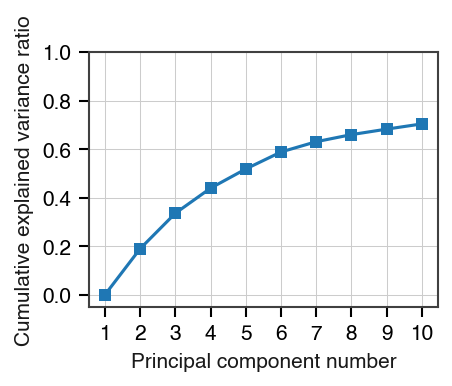

In [22]:
fig, ax = plt.subplots()
ax.bar(np.arange(1, len(r_list)+1), r_list)
ax.set_xticks(np.arange(1, len(r_list)+1))
ax.set_xlabel('Principal component number')
ax.set_ylabel(r"Pearson's r (vs growth rate)")
ax.set_ylim(-0.8, 0.8)
if save_figs:
    plt.savefig(figs_dir+'/pca_correlation.pdf', bbox_inches='tight')

cum_var = []
for i,j in enumerate(pca.explained_variance_ratio_):
    cum_var.append(np.sum(pca.explained_variance_ratio_[:i]))
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(cum_var)+1), cum_var, marker='s')
ax.set_xticks(np.arange(1, len(cum_var)+1))
ax.set_xlabel('Principal component number')
ax.set_ylabel('Cumulative explained variance ratio')
ax.set_ylim(-0.05, 1.0)
if save_figs:
    plt.savefig(figs_dir+'/pca_variance.pdf', bbox_inches='tight')

## An interesting hunch / observation / side-bar using the GINI coefficient

In [23]:
def gini(x, w=None):
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

gini_vals = exp_df.apply(gini, axis=0)

SpearmanrResult(correlation=0.6978630670908461, pvalue=2.576178239973734e-16)


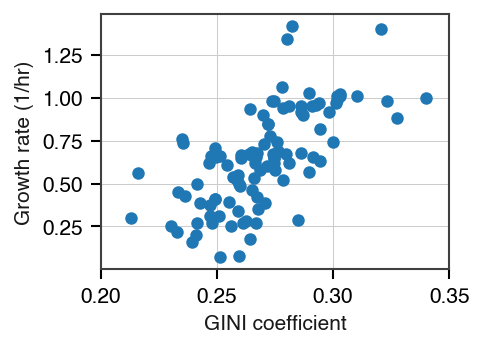

In [24]:
fig, ax = plt.subplots()
ax.plot(gini_vals, meta_df['Growth Rate (1/hr)'], marker='o', linestyle='')
assert max(gini_vals) < 0.35
ax.set_xlim(0.2, 0.35)
ax.set_xlabel('GINI coefficient')
ax.set_ylabel('Growth rate (1/hr)')
if save_figs:
    plt.savefig(figs_dir+'/gini_vs_growth.pdf', bbox_inches='tight')

print(stats.spearmanr(gini_vals, meta_df['Growth Rate (1/hr)']))

## Assess individual gene correlations with the growth rate data

I'm only doing a single randomization/permutation here, and it should of course be noted that this randomization is a bit unfair since it destroys the underlying correlation structure between conditions. However, a permutation strategy that accounts for that structure would be very difficult and the only point here is to show that there are some genes that are more/less correlated with growth than you might expect by chance alone.

In [25]:
tempy = []
tempy_rando = []
for index in exp_df.index:
    r, p = stats.pearsonr(exp_df.loc[index], meta_df['Growth Rate (1/hr)'])
    tempy.append((index, r, p))
    r, p = stats.pearsonr(np.random.permutation(exp_df.loc[index].values), meta_df['Growth Rate (1/hr)'])
    tempy_rando.append((index, r, p))
tempy.sort(key=lambda x: x[1])
tempy_rando.sort(key=lambda x: x[1])

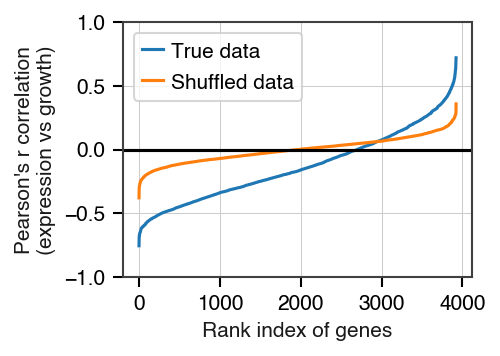

In [26]:
fig, ax = plt.subplots()
ax.plot([i[1] for i in tempy], label='True data')
ax.plot([i[1] for i in tempy_rando], label='Shuffled data')
ax.axhline(0, c='k')
ax.set_xlabel('Rank index of genes')
ax.set_ylabel('Pearson\'s r correlation\n(expression vs growth)')
plt.legend()
ax.set_ylim(-1.0, 1.0)
if save_figs:
    plt.savefig(figs_dir+'/rank_genes_growth.pdf', bbox_inches='tight')

-0.7550622608400182 0.7202138708192735


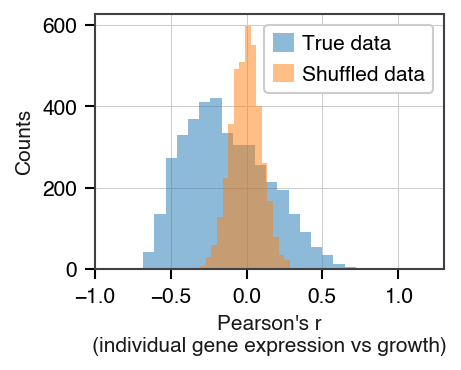

In [27]:
fig, ax = plt.subplots()
ax.hist([i[1] for i in tempy], 20, label='True data', alpha=0.5)
ax.hist([i[1] for i in tempy_rando], 20, label='Shuffled data', alpha=0.5)
ax.set_xlabel('Pearson\'s r\n(individual gene expression vs growth)')
ax.set_ylabel('Counts')
plt.legend(framealpha=1)
ax.set_xlim(-1.0, 1.3)
if save_figs:
    plt.savefig(figs_dir+'/hist_genes_growth.pdf', bbox_inches='tight')
print(np.min([i[1] for i in tempy]), np.max([i[1] for i in tempy]))

## Finding representative examples of genes

b4658_2 3.06439444395583
b4658_1 3.7028492557703894
b1533 5.664388499259191
b2538 4.9514232943572605
b1985 3.936318100587961
b1259 2.488104187235281
b0953 9.436766861121992
b3073 7.080314209979955
b1607 4.750192150841198
b1489 3.934471462396405


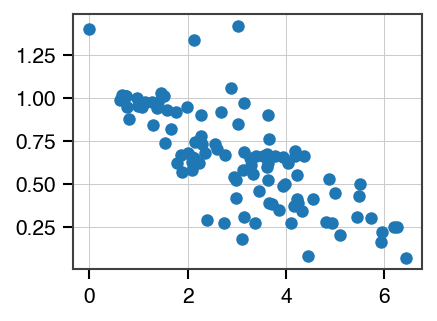

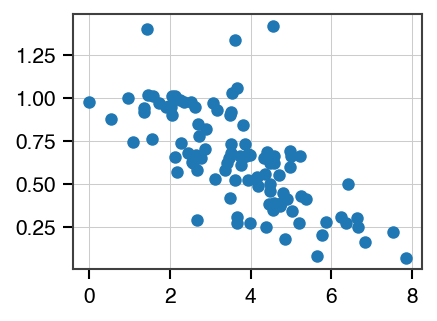

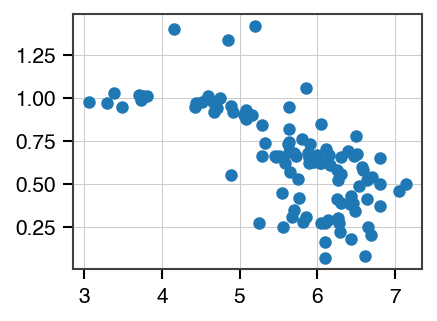

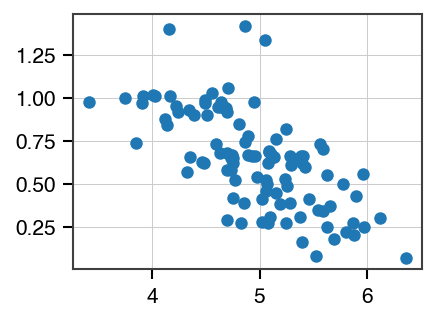

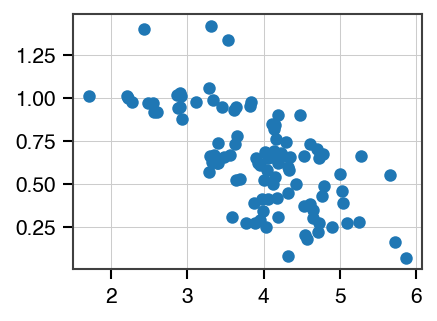

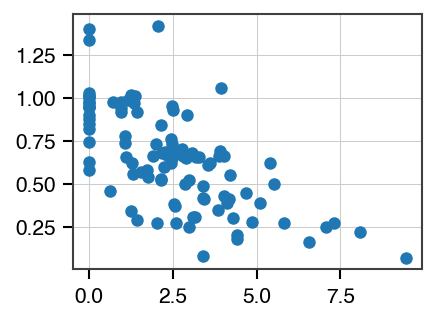

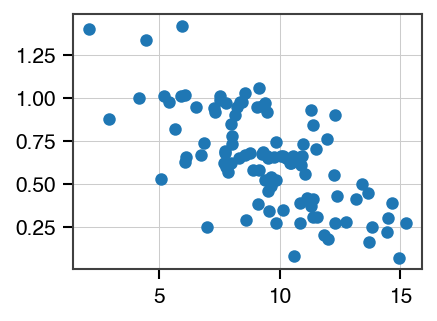

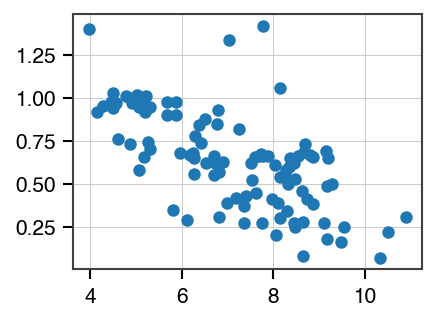

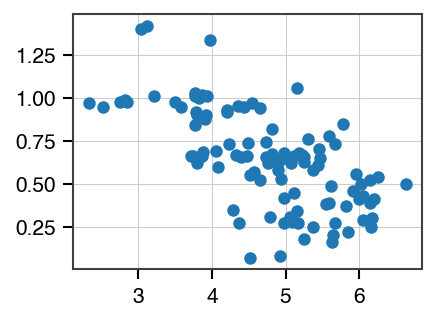

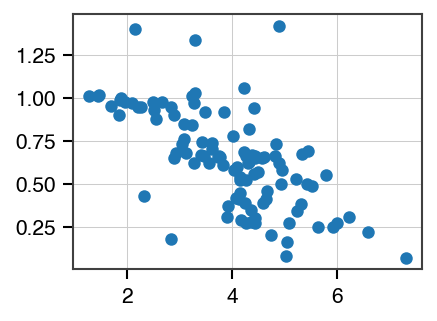

In [28]:
for i in tempy[:10]:
    fig, ax = plt.subplots()
    ax.plot(exp_df.loc[i[0]], meta_df['Growth Rate (1/hr)'], marker='o', linestyle='')
    print(i[0], exp_df.loc[i[0]].mean())

b3339 14.182324082298154
b3176 8.48826991062256
b0893 9.684601779030348
b3294 11.718292971763805
b3313 11.665870349044274
b1095 9.757356018551992
b0154 8.213076960884367
b4328 6.41991565443437
b0170 10.801267964925856
b2780 9.504768951630112


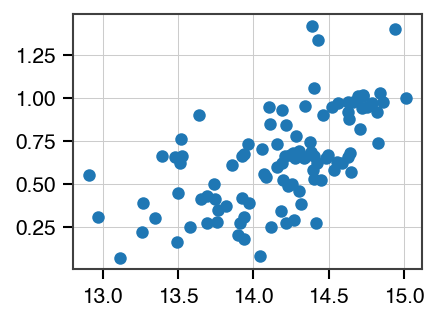

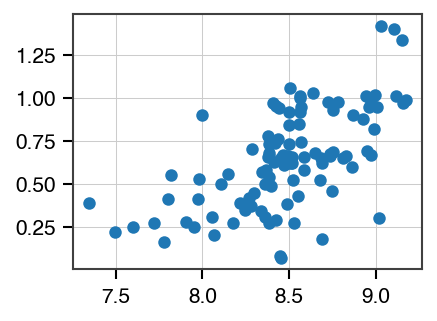

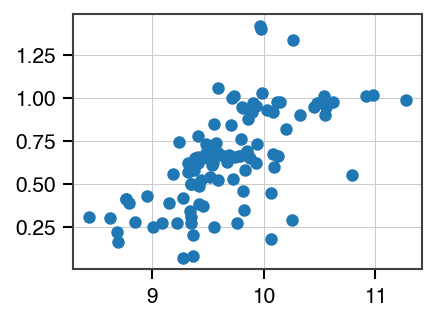

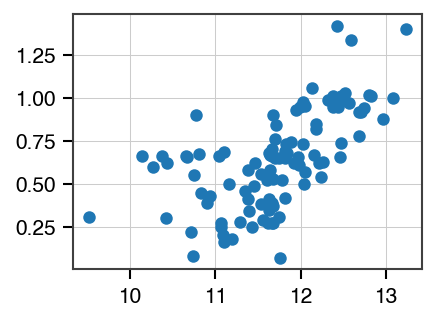

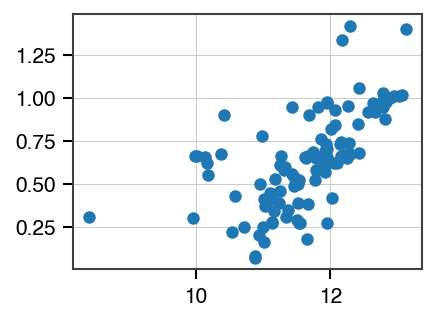

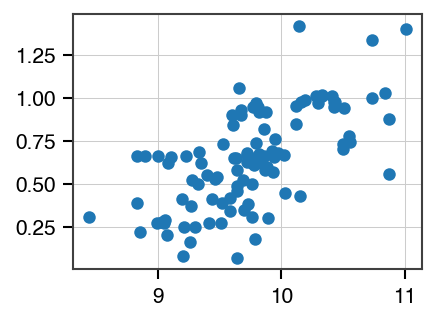

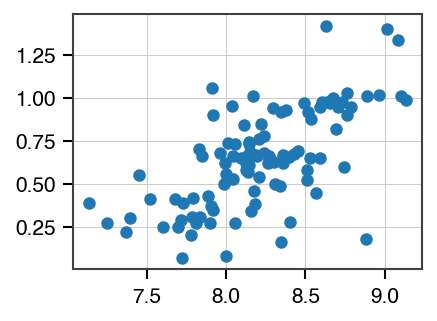

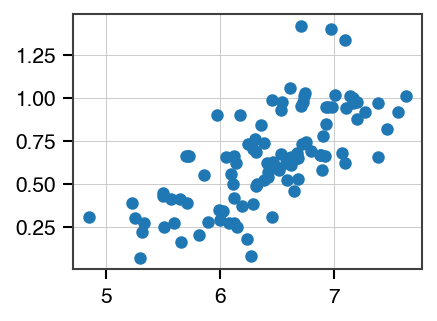

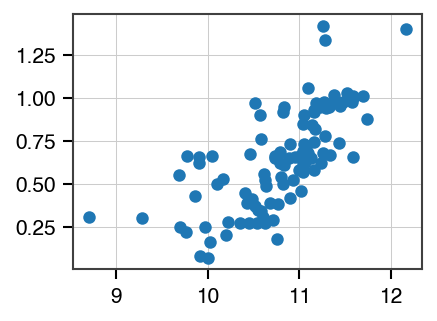

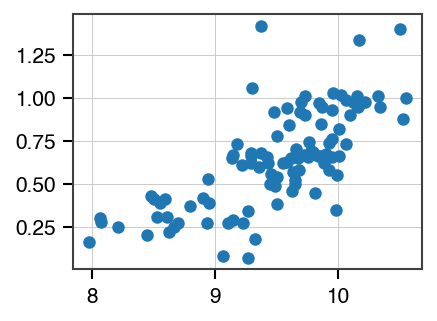

In [29]:
for i in tempy[-10:]:
    fig, ax = plt.subplots()
    ax.plot(exp_df.loc[i[0]], meta_df['Growth Rate (1/hr)'], marker='o', linestyle='')
    print(i[0], exp_df.loc[i[0]].mean())

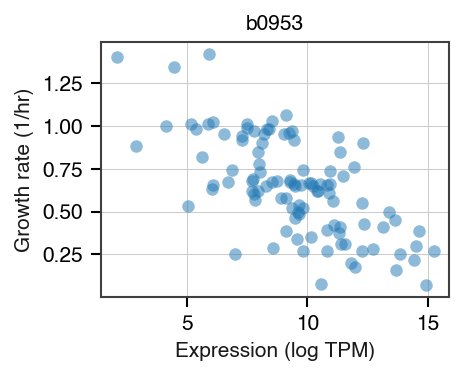

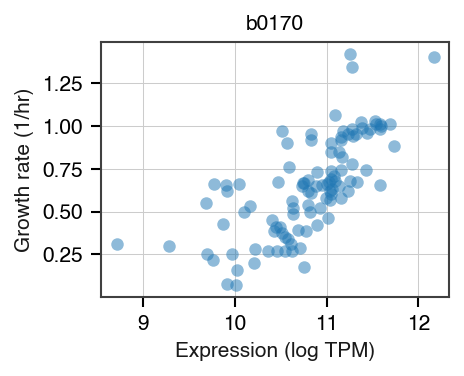

In [30]:
ltag = 'b0953'
fig, ax = plt.subplots()
ax.plot(exp_df.loc[ltag], meta_df['Growth Rate (1/hr)'], marker='o', linestyle='', alpha=0.5)
ax.set_title(ltag);
ax.set_xlabel('Expression (log TPM)');
ax.set_ylabel('Growth rate (1/hr)');
if save_figs:
    plt.savefig(figs_dir+'/{}_example.pdf'.format(ltag), bbox_inches='tight')

ltag = 'b0170'
fig, ax = plt.subplots()
ax.plot(exp_df.loc[ltag], meta_df['Growth Rate (1/hr)'], marker='o', linestyle='', alpha=0.5)
ax.set_title(ltag);
ax.set_xlabel('Expression (log TPM)');
ax.set_ylabel('Growth rate (1/hr)');
if save_figs:
    plt.savefig(figs_dir+'/{}_example.pdf'.format(ltag), bbox_inches='tight')

# Expression vs growth correlation

In [31]:
fitted = smf.ols('mean ~ lin_r', data=exp_summary_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     637.4
Date:                Tue, 23 Mar 2021   Prob (F-statistic):          1.89e-130
Time:                        16:29:46   Log-Likelihood:                -8787.8
No. Observations:                3923   AIC:                         1.758e+04
Df Residuals:                    3921   BIC:                         1.759e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0178      0.040    148.865      0.000       5.939       6.097
lin_r          3.3602      0.133     25.248      0.000       3.099       3.621
==============================================================================
Omnibus:                       17.654   Durbin-Watson:                   1.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.597
Skew:                           0.078   Prob(JB):                     0.000677
Kurtosis:                       2.745   Cond. No.                         3.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

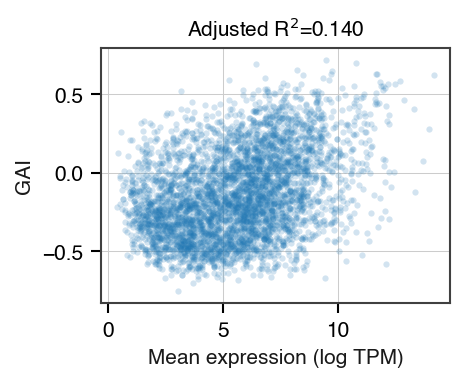

In [32]:
fig, ax = plt.subplots()
ax.plot(exp_summary_df['mean'], exp_summary_df['lin_r'], marker='.', linestyle='', alpha=0.2)
ax.set_xlabel('Mean expression (log TPM)')
ax.set_ylabel('GAI')
ax.set_title(r'Adjusted R$^2$={:.3f}'.format(fitted.rsquared_adj))
if save_figs:
    plt.savefig(figs_dir+'/mean_vs_GAI.pdf', bbox_inches='tight')